In [5]:
import secrets

# import easydict
import matplotlib.pyplot as plt
import torch
# from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torch.utils.data as data
from tqdm import tqdm
import pandas as pd
import numpy as np

# from model import LSTMVAE
from numpy import recarray
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch.utils.data as data
import os

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
from torch import nn
from torch.nn import functional as F
import os
from torch.nn.utils.rnn import pad_sequence
import copy
import platform

if torch.cuda.is_available():
    device = 'cuda'
    print('on cuda')
if torch.backends.mps.is_available():
    device = 'mps'
    print('on mps')
else:
    device = 'cpu'
    print('on cpu')
# device = 'cpu'

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.mps.manual_seed(RANDOM_SEED)

on mps


In [6]:
class mHealth(data.Dataset):

    def __init__(self, dataframe):
        """
        Args:
            csv_file (string): path to csv file with data
        """
        self.dataset = dataframe

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        """
        Args:
            index (int): index

        Returns:
            (sequence, [128, 3])
            returns the time series data of length 128 
            (X-axis, Y-axis, Z-axis)
        """
        #return sequence of length 128 x 3
        sequence = torch.tensor(self.dataset[index:index+128].to_numpy()).type(torch.float32) 
        sequence = sequence.unsqueeze(dim=1)
        
        return sequence

def collate_fn(data):
    inputs = [torch.tensor(d) for d in data]

    inputs = pad_sequence(inputs, batch_first=True)

    return inputs

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )
        
        self.fc = nn.Linear(num_layers, 1)

    def forward(self, x):
        # print("encoder x shape: ", x.shape)
        # x = x.unsqueeze(dim=0)
        # x = x.permute(1, 2, 0)
        
        outputs, (hidden, cell) = self.lstm(x.to(device))
        
        
        # print("outputs shape: ", outputs.shape)
        # print('hidden shapeL ', hidden.shape, cell.shape)
        
        # hidden = hidden.permute(1, 2, 0)
        # cell = cell.permute(1, 2, 0)
        # print("outputs shape: ", outputs.shape)
        # print('hidden shapeL ', hidden.shape, cell.shape)
        # hidden = self.fc(hidden.to(device))
        # cell = self.fc(cell.to(device))
        
        # print("outputs shape: ", outputs.shape)
        # print('hidden shapeL ', hidden.shape, cell.shape)
        
        return outputs, (hidden, cell)


class Decoder(nn.Module):
    def __init__(
        self, input_size=1, hidden_size=64, output_size=1, num_layers=1):
        
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        print("decoder layers: ", self.num_layers)
        
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=False,
        )
        self.fc = nn.Linear(
            hidden_size,
            output_size
        )

    def forward(self, x, hidden):
        # print("decoder x shaep: ", x.shape)
        # x = x.reshape(512, 1, 64)
        # hidden = (hidden[0].unsqueeze(dim=0), hidden[1].unsqueeze(dim=0))
        hidden = (hidden[0], hidden[1])
        # print("x shape: ", x.shape)
        # print("hidden shaep: ", hidden[0].shape)
        # print("hidden shaep: ", hidden[1].shape)

        output, (hidden, cell) = self.lstm(x, hidden)

        prediction = self.fc(output)
        
        return prediction, (hidden, cell)


class LSTMVAE(nn.Module):
    """LSTM-based Variational Auto Encoder"""

    def __init__(
        self, input_size, hidden_size, latent_size, device
    ):
        """
        input_size: int, batch_size x sequence_length x input_dim
        hidden_size: int, output size of LSTM AE
        latent_size: int, latent z-layer size
        num_lstm_layer: int, number of layers in LSTM
        """
        super(LSTMVAE, self).__init__()
        self.device = device

        # dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = 4

        # lstm ae
        self.lstm_enc = Encoder(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=self.num_layers
        )

        self.lstm_dec = Decoder(
            input_size=latent_size,
            output_size=input_size,
            hidden_size=hidden_size,
            num_layers=self.num_layers,
        )

        self.fc21 = nn.Linear(self.hidden_size, self.latent_size) #expected input: [64, 0]
        self.fc22 = nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = nn.Linear(self.latent_size, self.hidden_size)
        self.fc_fix = nn.Linear(128 * self.num_layers, 128)

    def reparametize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        noise = torch.randn_like(std).to(self.device)

        z = mu + noise * std
        return z

    def forward(self, x):
        # x = x.squeeze()
        # print("x shape: ", x.shape)
        batch_size, seq_len, feature_dim = x.shape

        # encode input space to hidden space
        outputs, enc_hidden = self.lstm_enc(x)
        # print("enc h deivce:", enc_hidden.shape)
        # enc_h = enc_hidden[0].view(batch_size, self.hidden_size).to(self.device)
        enc_h = enc_hidden[0].view(self.num_layers, batch_size, self.hidden_size).to(self.device)

        mean = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparametize(mean, logvar)  # batch_size x latent_size
        h_ = self.fc3(z)

        # decode latent space to input space
        z = z.repeat(1, seq_len, 1)
        # print("z shape: ", z.shape)
        z = z.view(batch_size, seq_len * self.num_layers, self.latent_size).to(self.device)
        hidden = (h_.contiguous(), h_.contiguous())
        reconstruct_output, hidden = self.lstm_dec(z, hidden)
        x_hat = reconstruct_output.squeeze()
        
        # print("x hat : ", x_hat.shape)
        x_hat = self.fc_fix(x_hat)

        losses = self.loss_function(x_hat, x, mean, logvar)
        m_loss, recon_loss, kld_loss = (
            losses["loss"],
            losses["Reconstruction_Loss"],
            losses["KLD"],
        )

        return m_loss, x_hat, (recon_loss, kld_loss)

    def loss_function(self, *args, **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0].to(device).unsqueeze(dim=2)
        input = args[1].to(device)
        mu = args[2]
        log_var = args[3]

        kld_weight = 0.00025  # Account for the minibatch samples from the dataset

        # print("reconds shape: ", recons.shape)
        # print("input shape: ", input.shape)
        recons_loss = F.mse_loss(recons, input)

        kld_loss = torch.mean(
            -0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0
        )

        loss = recons_loss + kld_weight * kld_loss
        return {
            "loss": loss,
            "Reconstruction_Loss": recons_loss.detach(),
            "KLD": -kld_loss.detach(),
        }

In [ ]:
class LatentClassifier(nn.Module):
    def __init__(
        self, input_size, hidden_size, num_classes, device
    ):
        """
        input_size: int, size of latent, 
        hidden_size: int, 
        num_classes: int, num of activities in dataset
        """
        super(LSTMVAE, self).__init__()
        self.device = device
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.device = device
        
        self.classifier = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.Linear(self.hidden_size, self.num_classes),
        )
        
    def forward(self, x):
        return self.classifier(x)

hi


0        -9.8184
1        -9.8489
2        -9.6602
3        -9.6507
4        -9.7030
           ...  
161275   -9.4032
161276   -9.5201
161277   -9.3682
161278   -8.6702
161279   -8.7211
Name: chest acceleration X-axis, Length: 161280, dtype: float64

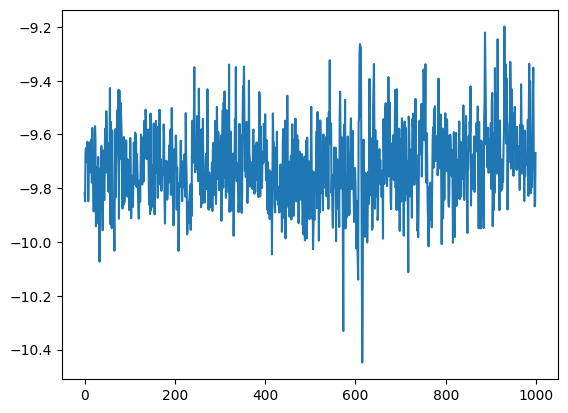

In [7]:
if(platform.system() == 'Darwin'):
    print('hi')

dataset_path = os.getcwd() + '/processed_data/mHealth_subject1.csv'

dataset = pd.read_csv(dataset_path)
dataset = dataset['chest acceleration X-axis'] #drop all columns that aren't chest accel info
plt.plot(dataset[:1000])

dataset

In [33]:
LOAD_MODEL = True
split_idx = int(len(dataset//4) * 0.8)

# training dataset
train_set = mHealth(
    dataframe=dataset[:split_idx],
)

test_set = mHealth(
    dataframe=dataset[split_idx:],
)

whole_set = mHealth(
    dataframe=dataset,
)

batch_size = 512
input_size = 1
hidden_size = 64
latent_size = 8
num_layers = 4

print(device)

if(LOAD_MODEL):
    model = LSTMVAE(input_size, hidden_size, latent_size, device=device)
    if(platform.system() == 'Darwin'):
        model.load_state_dict(torch.load('/Users/jm/VS Code/Python/pythonenv/gait-project/VAE+RNN/lstm_vae/1_dim_4_layers_better_state_dict'))
    # if(platform.system() == 'Windows'):
        
    print("model loaded from state dict")
else:
    # define LSTM-based VAE model
    model = LSTMVAE(input_size, hidden_size, latent_size, device=device)

model.to(device)
print(train_set[128].shape)
print(model)

mps
decoder layers:  4
model loaded from state dict
torch.Size([128, 1])
LSTMVAE(
  (lstm_enc): Encoder(
    (lstm): LSTM(1, 64, num_layers=4, batch_first=True)
    (fc): Linear(in_features=4, out_features=1, bias=True)
  )
  (lstm_dec): Decoder(
    (lstm): LSTM(8, 64, num_layers=4, batch_first=True)
    (fc): Linear(in_features=64, out_features=1, bias=True)
  )
  (fc21): Linear(in_features=64, out_features=8, bias=True)
  (fc22): Linear(in_features=64, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=64, bias=True)
  (fc_fix): Linear(in_features=512, out_features=128, bias=True)
)


In [35]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

whole_loader = torch.utils.data.DataLoader(
    dataset=whole_set,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True
)

print(f"Dataloaders: {train_loader}")
print(f"Length of train_dataloader: {len(train_loader)} batches of {batch_size}")


for idx, data in enumerate(train_loader):
    datas = data
    # labels = data[1]
    print("datas shape: ", datas.shape)
    break
    print("Data shape:", datas.shape)
    #print("Labels:", labels)
   # ("Labels shape:", len(labels))
    print("labels shape", labels.shape)
    break

Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x152bcb490>
Length of train_dataloader: 252 batches of 512
datas shape:  torch.Size([512, 128, 1])


/var/folders/4p/ths4mw3d4gx2tp708qp5jbqr0000gn/T/ipykernel_59846/2176505894.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


In [132]:
train_loss = []
test_loss = []

def train(iterations, model, train_loader, test_loader):
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    ## interation setup
    epochs = tqdm(range(iterations // len(train_loader)))

    ## training
    count = 0
    for epoch in epochs:
        model.train()
        optimizer.zero_grad()
        train_iterator = tqdm(
            enumerate(train_loader), total=len(train_loader)-32, desc="training"
        )

        for i, batch_data in train_iterator:

            if count > iterations:
                return model
            count += 1

            past_data = batch_data

            mloss, recon_x, recon_loss = model(past_data)

            # Backward and optimize
            optimizer.zero_grad()
            mloss.mean().backward()
            optimizer.step()

            train_iterator.set_postfix({"train_loss": float(mloss.mean())})
            train_loss.append(float(mloss.mean()))


        model.eval()
        eval_loss = 0
        test_iterator = tqdm(
            enumerate(test_loader), total=len(test_loader), desc="testing"
        )

        with torch.no_grad():
            for i, batch_data in test_iterator:
                past_data = batch_data

                ## reshape
                batch_size = past_data.size(0)
                example_size = past_data.size(1)
                past_data = (
                    past_data.view(batch_size, example_size, -1).float().to(device)
                )

                mloss, recon_x, info = model(past_data)

                eval_loss += mloss.mean().item()

                test_iterator.set_postfix({"eval_loss": float(mloss.mean())})
                test_loss.append(float(mloss.mean()))

        eval_loss = eval_loss / len(test_loader)
        # writer.add_scalar("eval_loss", float(eval_loss), epoch)
        print("Evaluation Score : [{}]".format(eval_loss))

    return model


In [133]:
iterations = 20000
train(iterations, model, train_loader, train_loader)
# # torch.save(model.state_dict(), '/home/jm/vscode/Python/pythonenv/gait-project/VAE+RNN/lstm_vae/model_state_dict')
# # torch.save(model.state_dict(), '/Users/jm/VS Code/Python/pythonenv/gait-project/VAE+RNN/lstm_vae/1_dim_state_dict')

  0%|          | 0/79 [00:00<?, ?it/s]/var/folders/4p/ths4mw3d4gx2tp708qp5jbqr0000gn/T/ipykernel_71551/2176505894.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]
training: 252it [02:07,  1.97it/s, train_loss=15.5]
  1%|▏         | 1/79 [02:43<3:31:56, 163.03s/it]

Evaluation Score : [14.747898344393997]


training: 252it [02:00,  2.08it/s, train_loss=17.5]
  3%|▎         | 2/79 [05:19<3:24:04, 159.02s/it]

Evaluation Score : [13.102413826282062]


training: 252it [02:00,  2.09it/s, train_loss=13.8]
  4%|▍         | 3/79 [07:54<3:19:29, 157.49s/it]

Evaluation Score : [12.848447815027265]


training: 252it [02:00,  2.08it/s, train_loss=13.4]
  5%|▌         | 4/79 [10:31<3:16:19, 157.06s/it]

Evaluation Score : [12.824454782264572]


training: 252it [02:01,  2.08it/s, train_loss=13.9]
  6%|▋         | 5/79 [13:07<3:13:21, 156.77s/it]

Evaluation Score : [12.318606893014577]


training: 252it [02:00,  2.10it/s, train_loss=13.1]
  8%|▊         | 6/79 [15:42<3:10:08, 156.28s/it]

Evaluation Score : [12.34212583989378]


training: 252it [02:01,  2.07it/s, train_loss=12.6]
  9%|▉         | 7/79 [18:19<3:07:43, 156.43s/it]

Evaluation Score : [12.547970838135196]


training: 252it [02:01,  2.08it/s, train_loss=12.6]
 10%|█         | 8/79 [20:55<3:05:03, 156.39s/it]

Evaluation Score : [13.239556009689021]


training: 252it [02:00,  2.08it/s, train_loss=12.9]
 11%|█▏        | 9/79 [23:32<3:02:24, 156.35s/it]

Evaluation Score : [12.899218832098303]


training: 252it [01:59,  2.10it/s, train_loss=13.2]
 13%|█▎        | 10/79 [26:07<2:59:19, 155.94s/it]

Evaluation Score : [12.778199121237748]


training: 252it [01:59,  2.11it/s, train_loss=14]
 14%|█▍        | 11/79 [28:41<2:56:12, 155.48s/it]

Evaluation Score : [12.746595920787918]


training: 252it [01:58,  2.13it/s, train_loss=12.8]
 15%|█▌        | 12/79 [31:14<2:52:51, 154.79s/it]

Evaluation Score : [12.577017421168941]


training: 252it [01:57,  2.15it/s, train_loss=12.7]
 16%|█▋        | 13/79 [33:46<2:49:17, 153.91s/it]

Evaluation Score : [12.721797351562788]


training: 252it [01:57,  2.15it/s, train_loss=13.1]
 18%|█▊        | 14/79 [36:18<2:46:04, 153.31s/it]

Evaluation Score : [11.934160891447275]


training: 252it [01:57,  2.15it/s, train_loss=13.3]
 19%|█▉        | 15/79 [38:50<2:43:03, 152.86s/it]

Evaluation Score : [12.70811544642562]


training: 252it [01:58,  2.13it/s, train_loss=14.4]
 20%|██        | 16/79 [41:23<2:40:27, 152.81s/it]

Evaluation Score : [12.619852809087625]


training: 252it [01:57,  2.15it/s, train_loss=14]
 22%|██▏       | 17/79 [43:55<2:37:37, 152.54s/it]

Evaluation Score : [12.427947309873407]


training: 252it [01:57,  2.14it/s, train_loss=15]
 23%|██▎       | 18/79 [46:27<2:34:55, 152.39s/it]

Evaluation Score : [12.642383510394701]


training: 252it [01:57,  2.15it/s, train_loss=13.3]
 24%|██▍       | 19/79 [48:59<2:32:16, 152.28s/it]

Evaluation Score : [11.910847625207333]


training: 252it [01:57,  2.15it/s, train_loss=16]
 25%|██▌       | 20/79 [51:31<2:29:38, 152.18s/it]

Evaluation Score : [12.254276692394226]


training: 252it [01:57,  2.15it/s, train_loss=20.4]
 27%|██▋       | 21/79 [54:02<2:26:58, 152.05s/it]

Evaluation Score : [13.497661449192535]


training: 252it [02:00,  2.09it/s, train_loss=14.1]
 28%|██▊       | 22/79 [56:37<2:25:18, 152.96s/it]

Evaluation Score : [13.0531671240571]


training: 252it [01:57,  2.14it/s, train_loss=11]
 29%|██▉       | 23/79 [59:10<2:22:37, 152.81s/it]

Evaluation Score : [12.164812577444883]


training: 252it [01:57,  2.15it/s, train_loss=12.4]
 30%|███       | 24/79 [1:01:42<2:19:49, 152.54s/it]

Evaluation Score : [11.863023856211276]


training: 252it [01:57,  2.15it/s, train_loss=11.6]
 32%|███▏      | 25/79 [1:04:13<2:16:59, 152.20s/it]

Evaluation Score : [11.606082056486418]


training: 252it [01:57,  2.14it/s, train_loss=10.4]
 33%|███▎      | 26/79 [1:06:45<2:14:26, 152.20s/it]

Evaluation Score : [10.47983291842753]


training: 252it [01:57,  2.15it/s, train_loss=10.9]
 34%|███▍      | 27/79 [1:09:17<2:11:46, 152.05s/it]

Evaluation Score : [12.009413601505377]


training: 252it [01:57,  2.15it/s, train_loss=10]
 35%|███▌      | 28/79 [1:11:49<2:09:08, 151.93s/it]

Evaluation Score : [12.590886269769971]


training: 252it [01:56,  2.16it/s, train_loss=11.6]
 37%|███▋      | 29/79 [1:14:20<2:06:27, 151.75s/it]

Evaluation Score : [11.88922037349807]


training: 252it [01:57,  2.14it/s, train_loss=10.2]
 38%|███▊      | 30/79 [1:16:52<2:04:01, 151.86s/it]

Evaluation Score : [11.849679568457224]


training: 252it [01:56,  2.15it/s, train_loss=10.1]
 39%|███▉      | 31/79 [1:19:24<2:01:26, 151.80s/it]

Evaluation Score : [12.183521702885628]


training: 252it [01:57,  2.15it/s, train_loss=9.9]
 41%|████      | 32/79 [1:21:55<1:58:51, 151.73s/it]

Evaluation Score : [11.64804403945094]


training: 252it [01:57,  2.15it/s, train_loss=10.2]
 42%|████▏     | 33/79 [1:24:27<1:56:19, 151.73s/it]

Evaluation Score : [11.732384914798397]


training: 252it [01:57,  2.15it/s, train_loss=17.8]
 43%|████▎     | 34/79 [1:26:59<1:53:45, 151.67s/it]

Evaluation Score : [11.912190951288693]


training: 252it [01:57,  2.15it/s, train_loss=10.7]
 44%|████▍     | 35/79 [1:29:31<1:51:16, 151.73s/it]

Evaluation Score : [11.04465949020925]


training: 252it [01:57,  2.15it/s, train_loss=10.5]
 46%|████▌     | 36/79 [1:32:02<1:48:46, 151.77s/it]

Evaluation Score : [10.354128344280143]


training: 252it [01:57,  2.15it/s, train_loss=10.5]
 47%|████▋     | 37/79 [1:34:34<1:46:12, 151.73s/it]

Evaluation Score : [10.300363957556703]


training: 252it [01:57,  2.15it/s, train_loss=10.9]
 48%|████▊     | 38/79 [1:37:06<1:43:41, 151.74s/it]

Evaluation Score : [9.924364191494764]


training: 252it [01:57,  2.15it/s, train_loss=10.5]
 49%|████▉     | 39/79 [1:39:37<1:41:08, 151.71s/it]

Evaluation Score : [10.237651181244662]


training: 252it [01:57,  2.15it/s, train_loss=10.8]
 51%|█████     | 40/79 [1:42:09<1:38:35, 151.68s/it]

Evaluation Score : [10.740472764279398]


training: 252it [01:56,  2.16it/s, train_loss=13.9]
 52%|█████▏    | 41/79 [1:44:41<1:36:03, 151.67s/it]

Evaluation Score : [10.387719913193632]


training: 252it [01:56,  2.16it/s, train_loss=16.2]
 53%|█████▎    | 42/79 [1:47:12<1:33:28, 151.58s/it]

Evaluation Score : [12.224504663446357]


training: 252it [01:56,  2.16it/s, train_loss=12.3]
 54%|█████▍    | 43/79 [1:49:44<1:30:55, 151.55s/it]

Evaluation Score : [10.478328006667278]


training: 252it [02:01,  2.08it/s, train_loss=15.1]
 56%|█████▌    | 44/79 [1:52:20<1:29:10, 152.86s/it]

Evaluation Score : [11.75550046356188]


training: 252it [02:01,  2.08it/s, train_loss=15.3]
 57%|█████▋    | 45/79 [1:54:55<1:27:07, 153.74s/it]

Evaluation Score : [9.834679321045913]


training: 252it [02:01,  2.07it/s, train_loss=15.5]
 58%|█████▊    | 46/79 [1:57:32<1:25:03, 154.65s/it]

Evaluation Score : [9.830261368777544]


training: 252it [02:02,  2.06it/s, train_loss=15.6]
 59%|█████▉    | 47/79 [2:00:09<1:22:48, 155.27s/it]

Evaluation Score : [9.782745335960673]


training: 252it [02:02,  2.06it/s, train_loss=15.7]
 61%|██████    | 48/79 [2:02:47<1:20:38, 156.08s/it]

Evaluation Score : [9.4726789659037]


training: 252it [02:04,  2.02it/s, train_loss=15.7]
 62%|██████▏   | 49/79 [2:05:27<1:18:42, 157.41s/it]

Evaluation Score : [9.369438657684931]


training: 252it [02:07,  1.98it/s, train_loss=15.6]
 63%|██████▎   | 50/79 [2:08:10<1:16:53, 159.08s/it]

Evaluation Score : [9.559456591243071]


training: 252it [02:02,  2.06it/s, train_loss=15.7]
 65%|██████▍   | 51/79 [2:10:49<1:14:11, 158.98s/it]

Evaluation Score : [10.236982506655512]


training: 252it [02:01,  2.08it/s, train_loss=15.5]
 66%|██████▌   | 52/79 [2:13:25<1:11:08, 158.09s/it]

Evaluation Score : [9.36276415750266]


training: 252it [02:01,  2.07it/s, train_loss=15.5]
 67%|██████▋   | 53/79 [2:16:01<1:08:17, 157.60s/it]

Evaluation Score : [9.120352196906294]


training: 252it [02:01,  2.08it/s, train_loss=15.3]
 68%|██████▊   | 54/79 [2:18:37<1:05:27, 157.10s/it]

Evaluation Score : [9.325556337626445]


training: 252it [02:02,  2.06it/s, train_loss=15]
 70%|██████▉   | 55/79 [2:21:14<1:02:49, 157.07s/it]

Evaluation Score : [11.158319977422556]


training: 252it [02:00,  2.09it/s, train_loss=14.5]
 71%|███████   | 56/79 [2:23:50<1:00:00, 156.54s/it]

Evaluation Score : [10.16080909169146]


training: 252it [02:03,  2.05it/s, train_loss=15]
 72%|███████▏  | 57/79 [2:26:28<57:33, 156.97s/it]  

Evaluation Score : [11.114026655871717]


training: 252it [02:01,  2.08it/s, train_loss=14.6]
 73%|███████▎  | 58/79 [2:29:04<54:50, 156.67s/it]

Evaluation Score : [9.475497661897588]


training: 252it [02:01,  2.07it/s, train_loss=10.3]
 75%|███████▍  | 59/79 [2:31:40<52:11, 156.58s/it]

Evaluation Score : [8.95786125745092]


training: 252it [02:00,  2.09it/s, train_loss=10.5]
 76%|███████▌  | 60/79 [2:34:15<49:26, 156.11s/it]

Evaluation Score : [8.916571913434872]


training: 252it [02:03,  2.04it/s, train_loss=10.2]
 77%|███████▋  | 61/79 [2:36:53<46:59, 156.63s/it]

Evaluation Score : [8.761507696398194]


training: 252it [02:00,  2.09it/s, train_loss=9.89]
 78%|███████▊  | 62/79 [2:39:28<44:15, 156.20s/it]

Evaluation Score : [8.606531973011673]


training: 252it [02:00,  2.09it/s, train_loss=9.68]
 80%|███████▉  | 63/79 [2:42:03<41:34, 155.88s/it]

Evaluation Score : [8.291087161660904]


training: 252it [02:00,  2.09it/s, train_loss=8.49]
 81%|████████  | 64/79 [2:44:38<38:54, 155.66s/it]

Evaluation Score : [8.62452156622968]


training: 252it [02:00,  2.09it/s, train_loss=8.81]
 82%|████████▏ | 65/79 [2:47:14<36:17, 155.56s/it]

Evaluation Score : [8.684580100256772]


training: 252it [01:59,  2.11it/s, train_loss=9.88]
 84%|████████▎ | 66/79 [2:49:48<33:36, 155.12s/it]

Evaluation Score : [9.805339665521705]


training: 252it [02:00,  2.09it/s, train_loss=10.6]
 85%|████████▍ | 67/79 [2:52:23<31:01, 155.15s/it]

Evaluation Score : [9.104950276099974]


training: 252it [02:01,  2.07it/s, train_loss=11.7]
 86%|████████▌ | 68/79 [2:54:59<28:29, 155.44s/it]

Evaluation Score : [9.096343249496487]


training: 252it [02:00,  2.09it/s, train_loss=9.79]
 87%|████████▋ | 69/79 [2:57:34<25:54, 155.40s/it]

Evaluation Score : [9.077459721426878]


training: 252it [01:59,  2.10it/s, train_loss=9.22]
 89%|████████▊ | 70/79 [3:00:09<23:16, 155.17s/it]

Evaluation Score : [10.439547294129929]


training: 252it [02:00,  2.10it/s, train_loss=8.48]
 90%|████████▉ | 71/79 [3:02:44<20:40, 155.07s/it]

Evaluation Score : [8.631497004557223]


training: 252it [02:01,  2.07it/s, train_loss=9.41]
 91%|█████████ | 72/79 [3:05:20<18:08, 155.50s/it]

Evaluation Score : [8.227834957341353]


training: 252it [02:03,  2.04it/s, train_loss=7.88]
 92%|█████████▏| 73/79 [3:07:59<15:38, 156.34s/it]

Evaluation Score : [8.972116686995067]


training: 252it [02:01,  2.07it/s, train_loss=7.86]
 94%|█████████▎| 74/79 [3:10:35<13:01, 156.34s/it]

Evaluation Score : [8.47960137102812]


training: 252it [02:03,  2.05it/s, train_loss=8.28]
 95%|█████████▍| 75/79 [3:13:13<10:27, 156.87s/it]

Evaluation Score : [8.18313155287788]


training: 252it [02:00,  2.09it/s, train_loss=8.17]
 96%|█████████▌| 76/79 [3:15:49<07:49, 156.43s/it]

Evaluation Score : [8.07540834440835]


training: 252it [02:01,  2.08it/s, train_loss=8.19]
 97%|█████████▋| 77/79 [3:18:24<05:12, 156.23s/it]

Evaluation Score : [8.10417214231122]


training: 252it [02:00,  2.10it/s, train_loss=8.09]
 99%|█████████▊| 78/79 [3:20:59<02:35, 155.92s/it]

Evaluation Score : [9.151921587330955]


training: 252it [01:59,  2.11it/s, train_loss=9.54]
100%|██████████| 79/79 [3:23:33<00:00, 154.61s/it]

Evaluation Score : [8.546072625983802]


LSTMVAE(
  (lstm_enc): Encoder(
    (lstm): LSTM(1, 64, num_layers=4, batch_first=True)
    (fc): Linear(in_features=4, out_features=1, bias=True)
  )
  (lstm_dec): Decoder(
    (lstm): LSTM(8, 64, num_layers=4, batch_first=True)
    (fc): Linear(in_features=64, out_features=1, bias=True)
  )
  (fc21): Linear(in_features=64, out_features=8, bias=True)
  (fc22): Linear(in_features=64, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=64, bias=True)
  (fc_fix): Linear(in_features=512, out_features=128, bias=True)
)

In [22]:
def predict(model, dataloader):
    model.eval()
    all_outputs = []
    with torch.no_grad():
        for batch in dataloader:
            # print(batch.shape)
            x = batch  # Assuming batch is a tuple (data, target), adjust if necessary
            # print("x shape: ", x.shape)
            ## reshape
            batch_size = x.size(0)
            example_size = x.size(1)
            x = (
                x.view(batch_size, example_size, -1).float().to(device)
            )
            # print('x shape: ', x.shape)
            mloss, recon_x, info = model(x)
            
            # print("recon x shape: ", recon_x.shape)
            recon_x = recon_x[:, 0]
            # print("recon x shape: ", recon_x.shape)
            all_outputs.append(recon_x)
    return torch.cat(all_outputs, dim=0)

In [23]:
print(len(train_loader))

129024


In [24]:
reconstruction = predict(model, train_loader)

/var/folders/4p/ths4mw3d4gx2tp708qp5jbqr0000gn/T/ipykernel_59846/2176505894.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


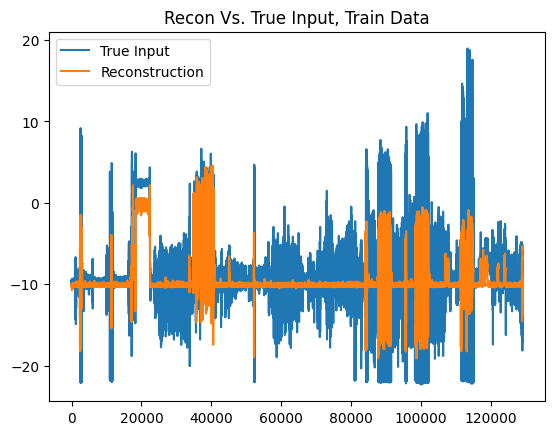

In [31]:
plt.plot(dataset[:split_idx], label="True Input")
plt.plot(reconstruction.cpu(), label='Reconstruction')
plt.title("Recon Vs. True Input, Train Data")
plt.legend()

In [29]:
test_recon = predict(model, test_loader)

/var/folders/4p/ths4mw3d4gx2tp708qp5jbqr0000gn/T/ipykernel_59846/2176505894.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


In [36]:
whole_recon = predict(model, whole_loader)

/var/folders/4p/ths4mw3d4gx2tp708qp5jbqr0000gn/T/ipykernel_59846/2176505894.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


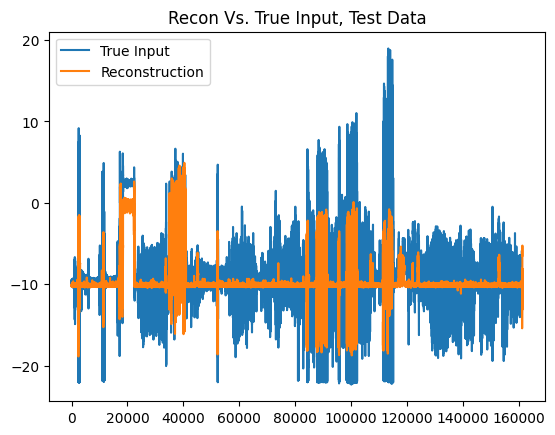

In [37]:
plt.plot(dataset, label="True Input")
plt.plot(whole_recon.cpu(), label='Reconstruction')
plt.title("Recon Vs. True Input, Test Data")
plt.legend()

In [139]:
reconstruction = reconstruction.squeeze()
reconstruction = reconstruction.cpu().numpy()

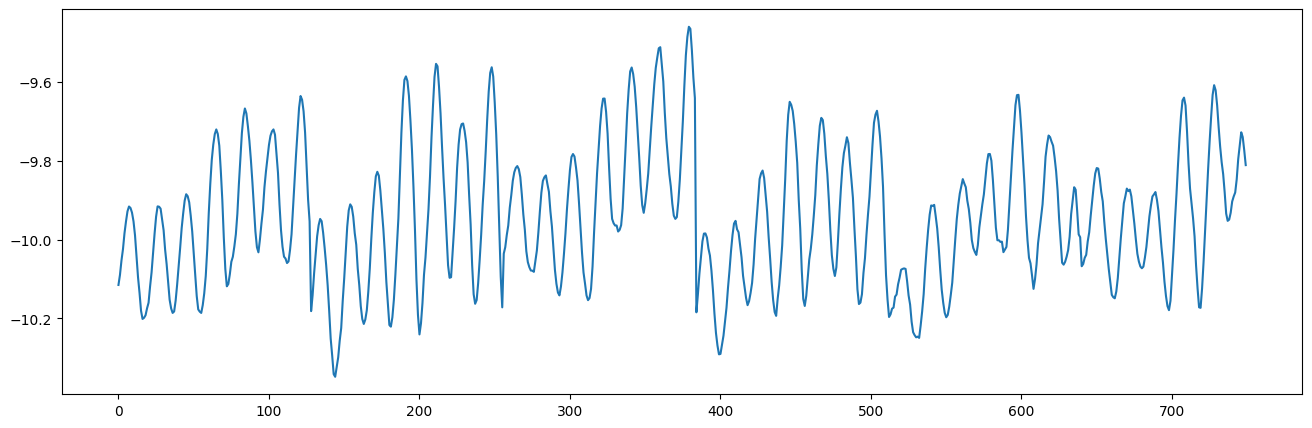

In [141]:
plt.figure(figsize=(16,5))
plt.plot(reconstruction[:750], label="Reconstructed Series")

Text(0.5, 0, 'Timestep')

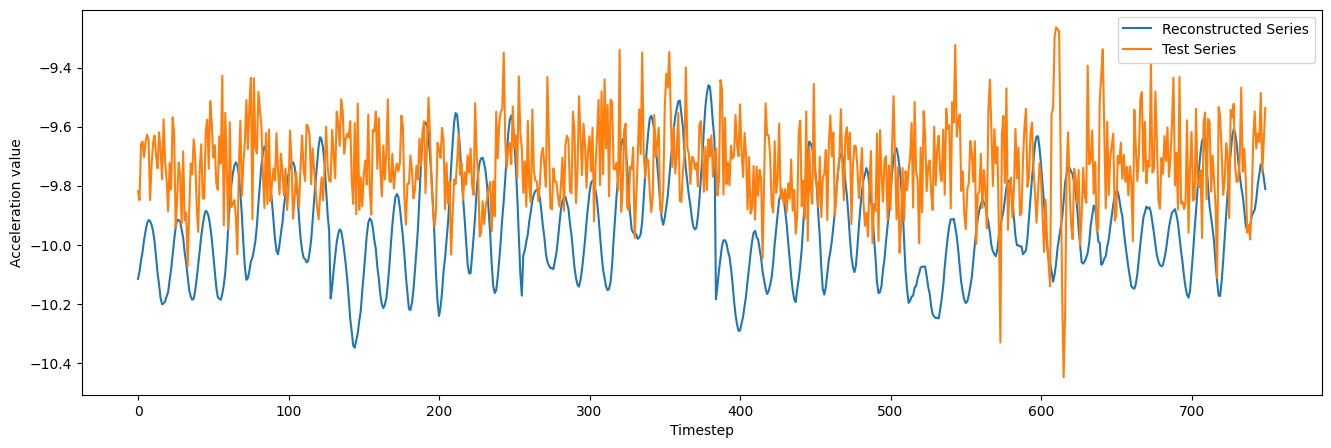

In [142]:
plt.figure(figsize=(16,5))
plt.plot(reconstruction[:750], label="Reconstructed Series")
plt.plot(dataset[:750], label='Test Series')
plt.legend()
plt.ylabel("Acceleration value")
plt.xlabel("Timestep")

In [146]:
def predict(model, dataset):
  predictions, losses = [], []
  # criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      # print('sequ true shape:', seq_true.shape)
      _, seq_pred, _ = model(seq_true)

      # loss = criterion(seq_pred, seq_true)
      # print(seq_pred.shape)
      predictions.append(seq_pred.cpu())
      # losses.append(loss.item())
  return predictions, losses


In [147]:
predictions, losses = predict(model, train_loader)

/var/folders/4p/ths4mw3d4gx2tp708qp5jbqr0000gn/T/ipykernel_71551/2176505894.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


In [154]:
# plt.plot(.cpu())

In [155]:
def predict(model, dataset):
  predictions, losses = [], []
#   criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      _, seq_pred, _ = model(seq_true)
      seq_pred = seq_pred[0, :]
    #   loss = criterion(seq_pred, seq_true)
      # print(seq_pred.shape)
      predictions.append(seq_pred.cpu().numpy().flatten())
    #   losses.append(loss.item())
  return predictions, losses

In [156]:
predictions, losses = predict(model, test_loader)

/var/folders/4p/ths4mw3d4gx2tp708qp5jbqr0000gn/T/ipykernel_71551/2176505894.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = [torch.tensor(d) for d in data]


In [157]:
len(predictions)

63

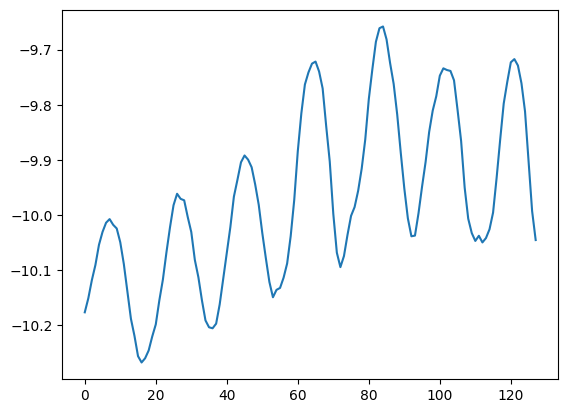

In [190]:
plt.plot(predictions[20])

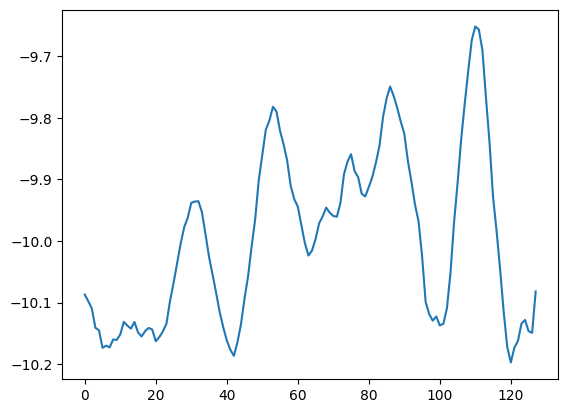

In [158]:
plt.plot(predictions[1])

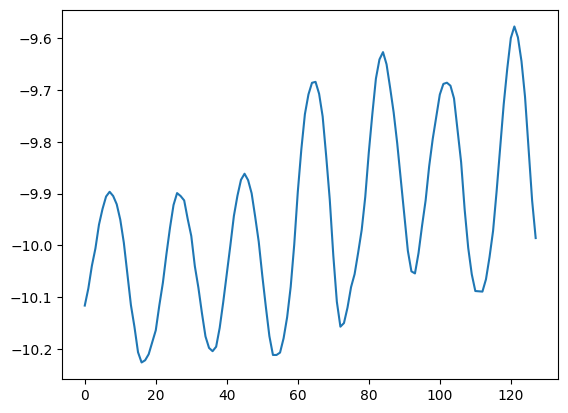

In [159]:
plt.plot(predictions[5])